# Homework 1

### CS328 — Numerical Methods for Visual Computing and Machine Learning
- - -

**Out** on Thursday 30/09/2021, **due** on Thursday 14/10/2021.

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please complete/extend this notebook for your homework submission:

* Begin your response to each problem with a <tt>&nbsp;<b>## Solution</b>&nbsp;&nbsp;</tt> markdown cell.
* In addition to your code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.
* Before handing in, please make sure that your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.anaconda.com/products/individual">Anaconda</a>, specifically the version based on Python 3.8.

<div class="alert alert-warning">
Homework assignments in CS328 count towards your final grade and must therefore be done individually.
</div>

### Prelude

The following fragment imports NumPy and Matplotlib and configures the latter to produce nice graphics on modern high-resolution screens. The import statements at the end establish a shorthand notation for the most common integer and floating point formats.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import random as rnd
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import factorial

from numpy import uint16  as u16
from numpy import uint32  as u32
from numpy import uint64  as u64
from numpy import float16 as f16
from numpy import float32 as f32
from numpy import float64 as f64

Two more definitions: the helper functions ``f2i`` and ``i2f``  below reinterpret floating point values as an integers and vice versa. We'll use these in Problem 3 to access the bit-level representation of an IEEE 754 floating point value.

In [2]:
def f2i(value):
    ''' Reinterpret floating point value as integer '''
    return value.view('u%i' % value.itemsize)

def i2f(value):
    ''' Reinterpret integer as floating point value '''
    return value.view('f%i' % value.itemsize)

## Problem 1: Images, slicing, and color balancing (15 pts)

The following two lines of code download a portrait photograph from the Wikipedia article on [color balance](https://en.wikipedia.org/wiki/Color_balance) and store it in a single precision NumPy array named ``image``, whose pixels are in the range ``[0.0, 1.0]``.

In [3]:
import PIL, requests
image = np.array(PIL.Image.open(requests.get('https://goo.gl/VcYNGN', stream=True, headers = {'User-agent': 'Mozilla/5.0'}).raw), dtype = np.float32) / 255

Try plotting this image using ``plt.imshow``.

## Solution 

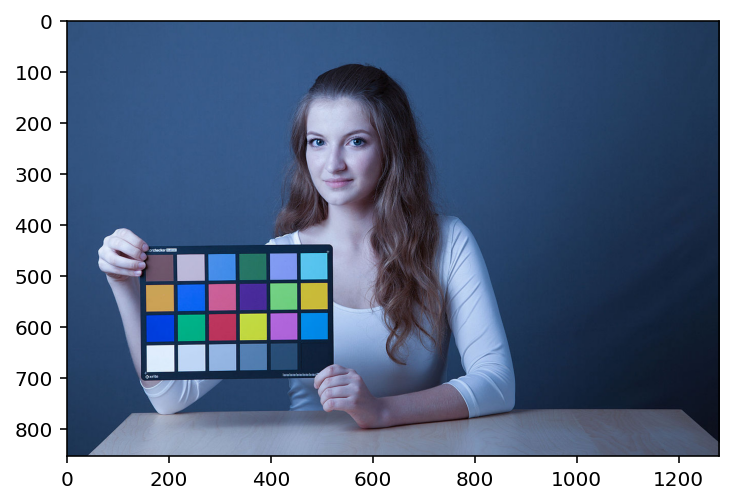

In [4]:
plt.imshow(image) ## plots the image

You will notice that the colors are distorted by a strong blue tint. Such intense color casts can lead to unnatural appearance and are usually not desired in portrait photography. In such cases, *color balancing* can be used to post-process the colors of an existing image to e.g. ensure that white objects indeed appear white in the image. One of the simplest kinds of color balancing is known as *white balancing*. Here, we select a region of the image that is known to contain a neutral color, and we then determine the reciprocal of the associated red, green, and blue color values. Afterwards, the color channels of the entire image are scaled by these reciprocals, ensuring that the selected region becomes neutral (i.e. it has similar amounts of red, green, and blue).

Note that the woman holds a [color checker](https://en.wikipedia.org/wiki/ColorChecker) in her hands. A color checker consists of an arrangement of colored patches with known color values, and the last row usually contains neutral colors. We will  use the second neutral patch on the bottom left to white-balance this image.

**TODO**: Use NumPy *slicing* operations to crop out the second neutral patch in the last row (counting from the left side) and plot it using ``plt.imshow``. The cropped region should be as large as possible without including the black frame or other patches.

## Solution 

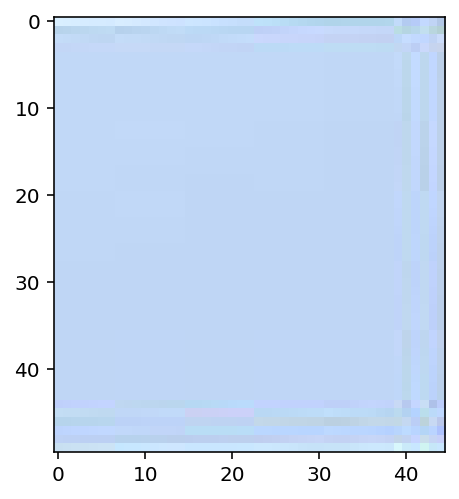

In [5]:
crop_image = image[636:686, 225:270] ## crops the image in order to get only the wanted patch
plt.imshow(crop_image) ## we plot the cropped image to check 

**TODO**: Compute the mean of the R, G, and B color channels over the patch. You should be able to accomplish this with a single function call to ``np.mean``. Print the computed mean using ``print()``.

## Solution 

In [6]:
mean = np.mean(crop_image, axis = (0, 1)) ## computes the mean of the colors over the patch 
print(mean)

[0.7519468 0.8426538 0.9633715]


**TODO**: Now, use *broadcasting* to multiply the image R, G, B channels by the reciprocals (inverses) of the values computed above and visualize the result using ``plt.imshow``. *Note*: You may need to scale the image by a small amount to prevent pixels overflowing to a value greater than ``1.0``, which will lead to strange color artifacts. (Our reference implementation uses a value of ``0.85``.)

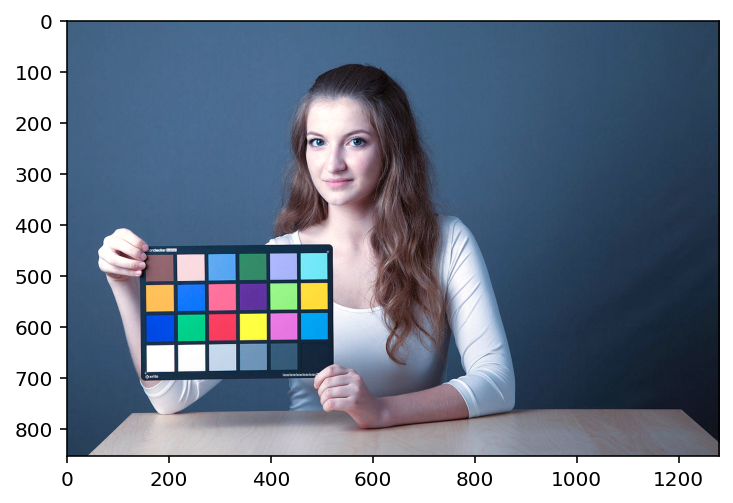

In [7]:
final_image = image * (1 / mean) ## we multiply the image by the reciprocal inverse of the values previously computed
scaled_image = np.clip(final_image, 0.0, 1.0) ## scales the image 
plt.imshow(scaled_image) ## We plot the image to see the final result

# Problem 2: Triple Birthday Paradox (25 pts)

Let us again consider the [Birthday Paradox](https://en.wikipedia.org/wiki/Birthday_problem) that was introduced during the first week's exercise session. In this task, we will study a slightly modified problem that can be summarized with the following question:

**What is the probability that at least *three* people in a random set of $n$ people share the same birthday?**

In the following, you will develop a simple numerical Python program to solve this problem and then make use of vectorization with NumPy arrays to speed it up. For this reason, you should use the "magic" Jupyter function ```%%time``` to profile the execution time of your implementation at every step.

## Problem 2.1: Basic Python Implementation (10 pts)

**TODO**: Write a basic Python program<a name="myfootnote1"><sup>[1]</sup></a> that estimates of the "3-birthdays probability" based on random sampling. 

Feel free to reuse code from the [first weeks notebook](https://moodle.epfl.ch/mod/resource/view.php?id=1084885) to get some inspiration on how you would do this.
The structure should stay exactly the same:
1. Choose $n$ random birthdays (i.e. integers)
2. Check if *three* of the birthdays are the same
3. Repeat this process $K$ times and keep track of how many times it was true
4. Return the ratio between "number successful events" and "total number events" ($K$)

When you chose $K$ large enough, a simulation like this should give you a good estimate of the true probability.

Remember that you can generate random integers by using *```randint```* from the *```random```* module:

```python
import random as rnd
a = rnd.randint(0, 10) # Random integer between 0 and 10 (including)
```
[[1]](#myfootnote1) Do **not** use any of the NumPy, SciPy, ... libraries in this part of the exercise—only pure Python is allowed.

In [8]:
## TODO... Fill in the inner loop of the following function
#
# For n people, compute an approximation of the probability that at
# least three people share the same birthday, using K iterations
def birthday_paradox_basic(n, K):
    counter = 0 # Keep track of how often the statement is true
    
    # Perform K iterations of the same experiment.
    for it in range(K):
        ## this generates n random ints between 0 and 365 (exculded)
        dates = [rnd.randint(0, 365) for i in range(n)]
        
        ## success is assigned to true if there exist an element in dates that appears at least 3 times
        ## which would mean that there exist at least 3 people who share the same birthday
        success = len([x for x in dates if dates.count(x) > 2]) > 0
        
        if success:
            counter += 1  
    
    # Return average probability
    return counter / K

To test if your program is operating correctly, try running it for $n=88$ people using a very high value of $K$ (e.g. ``100000``). This should give you (in expectation) a probability slightly above $0.5$:

In [9]:
print(birthday_paradox_basic(88, 100000))

0.50866


**TODO**: Finally, profile the running time of the implementation and report how much time it took for $K=100000$. You can do this simply by putting the ["magic command"](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) ``%%time`` at the top of the cell that should be timed:

In [10]:
%%time
birthday_paradox_basic(88, 100000)

CPU times: user 14.9 s, sys: 23.6 ms, total: 15 s
Wall time: 15 s


0.51021

## Problem 2.2: Vectorized implementation using NumPy (15 pts)

As you likely noticed, an implementation in pure Python is rather slow! As a frame of reference: an implementation with list comprehensions (as was done during the exercise session) can easily take half a minute to complete for large values of $K$ like above. Creating lists of random integers is a particularly slow operation that can be considerably accelerated using vectorized NumPy functions that process entire NumPy arrays at a once.

**TODO**: Write another function that computes the same result, but this time, replace the inner part of the "*```for it in range(K)```*" loop with a combination of NumPy array functions.<a name="myfootnote2"><sup>[2]</sup></a>

Here are a number of NumPy functions that you may find helpful:
* ```np.random.randint```
* ```np.bincount```
* ```np.unique```
* ```np.min, np.max```
* ```np.arange```
* ```np.any```

You can read about these in the [NumPy Documentation](https://numpy.org/doc/stable/).

**Hint**: The output range of ```np.random.randint``` differs slightly from ```random.randint``` provided by the standard library that you used above. Make sure not to introduce any subtle off-by-one errors!

[[2]](#myfootnote2) In this part of the exercise, do **not** use Python lists and list comprehensions, and do not explicitly iterate over the days of the year. Do **not** use ```np.vectorize```, ```np.apply_along_axis``` (or similar constructs) that merely emulate vectorization using a slow Python ``for`` loop internally.

In [11]:
## TODO... Fill in the inner loop of the following function

def birthday_paradox_numpy(n, K):
    counter = 0 # Keep track of how often the statement is true
    
    # Perform K iterations of the same experiment.
    for it in range(K):
        ## generates n random ints between 0 and 365 (excluded)
        dates = np.random.randint(0, 365, n)
        ## np.bincount returns an array with the number of occurrences of each value in dates
        ## hence we check if the max of this array is at least 3 
        success = np.max(np.bincount(dates)) > 2
        
        if success:
            counter += 1  
    
    # Return average probability
    return counter / K

**TODO**: Profile the running time of the implementation vectorized implementation for $K=100000$ like above and report the (approximate) speedup in a markdown cell or comment.

In [12]:
%%time
birthday_paradox_numpy(88, 100000)

CPU times: user 1.12 s, sys: 2.4 ms, total: 1.12 s
Wall time: 1.12 s


0.50957

## Solution

For the first implementation of the birthday paradox with pure python, it took 14.8 seconds to run it
For the second implementation using numpy, we got 1.14 second
Hence, the implementation using numpy is approximatively quicker by 13.66 seconds 

## Problem 2.3: Optional Exercise (0 points, not graded)
-- --
<br/>Although the vectorized implementation is a tremendous improvement, it still contains a loop over a potentially large number of virtual experiments. We can do better!

* Implement a version that fully relies on vectorized NumPy functions and contains no more loops. As above, do **not** use ```np.vectorize```, ```np.apply_along_axis``` (or similar constructs) that merely emulate vectorization using a slow Python ``for`` loop internally.
* Again, profile your code and report the speedup compared to both the "pure Python" and previous NumPy implementation. We expect to see at least some additional speedup here. (As a frame of reference, our solution to this problem achieves `~4x` speedup compared to problem 2.2.)



## Problem 3: Measuring error using ULPs (25 pts)
-- --

A special property of the IEEE754 floating point specification is that contiguous ranges of floating point numbers are also contiguous when re-interpreted as unsiged integers, e.g. by after applying the function ``f2i`` defined above. See the next figure for an illustration of this.

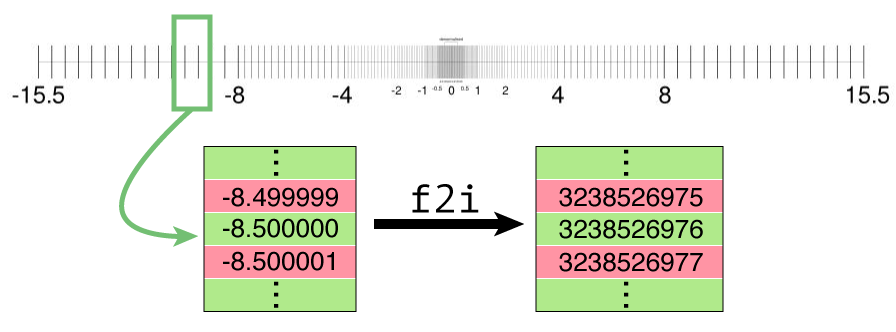

Use this property along with the functions ``f2i`` and ``i2f`` and the aliases ``f16`` etc. defined above to answer the following questions:

1. How many floating point values are located between the values ``1`` and ``2``, including the endpoints? How about ``1001`` and ``1002`` ? Give answers for 16, 32, and 64 bit precision variants. <br><br>

2. How large is 1 ULP for the value $\pi$ expressed in 64 bit arithmetic? Remember that one ULP was defined as the jump that occurred when changing the last mantissa bit from a ``1`` to a ``0`` (or vice versa).<br><br>

3. Suppose that we compute the surface area of the earth from its radius of $\approx 6.353\cdot 10^6m$ using the expression $A=4\pi r^2$. Assuming that the earth is perfectly spherical, and that the discretization of $\pi$ is the only source of error in this computation, bound the absolute error in square meters.

## Solution - Q1

In [13]:
print("Number of floating point values between 1 and 2 in 16 bits architecture :", f2i(f16(2.0)) - f2i(f16(1.0)) + 1)
print("Number of floating point values between 1001 and 1002 in 16 bits architecture :",f2i(f16(1002.0)) - f2i(f16(1001.0)) + 1, "\n")

print("Number of floating point values between 1 and 2 in 32 bits architecture :", f2i(f32(2.0)) - f2i(f32(1.0)) + 1)
print("Number of floating point values between 1001 and 1002 in 32 bits architecture :",f2i(f32(1002.0)) - f2i(f32(1001.0)) + 1, "\n")


print("Number of floating point values between 1 and 2 in 64 bits architecture :", f2i(f64(2.0)) - f2i(f64(1.0)) + 1)
print("Number of floating point values between 1001 and 1002 in 64 bits architecture :",f2i(f64(1002.0)) - f2i(f64(1001.0)) + 1, "\n")

Number of floating point values between 1 and 2 in 16 bits architecture : 1025
Number of floating point values between 1001 and 1002 in 16 bits architecture : 3 

Number of floating point values between 1 and 2 in 32 bits architecture : 8388609
Number of floating point values between 1001 and 1002 in 32 bits architecture : 16385 

Number of floating point values between 1 and 2 in 64 bits architecture : 4503599627370497.0
Number of floating point values between 1001 and 1002 in 64 bits architecture : 8796093022209.0 



Since every float value is mapped to an integer, we can do the difference of these integers to get the number
of floats between two values, that's what we did here.

We can observe logicly that there are a lot more values between 1 and 2 than between 1001 and 1002
We can also logicly observe that more floats can be represented with a 64 bits architecture thant with a 
32 or 16 since it has more bits to represent the values.

## Solution - Q2

In [14]:
pi_ulp = 1 / (f2i(f64(4.0)) - f2i(f64(3.0)) + 1)
print("ULP(pi) = ", pi_ulp)

ULP(pi) =  4.440892098500624e-16


We know that 3 < pi < 4. Hence, we compute the number of floating point values between 3 and 4 and then take
the inverse the know that gap between two floats between 3 and 4 in 64 bits architecture and hence the 
unit in the last place of pi.

## Solution - Q3


In [15]:
bound = 4.0 * 0.5 * pi_ulp * 6.353e6 * 6.353e6
print("Absolute error bound : ", bound)

Absolute error bound :  0.03584742191975464


The true value of pi (3.141592...) is between two floats a and b such that the distance between a and b
is is ulp(pi). Hence, if the true value of pi is above the half of this distance, it will be assigned to b,
and otherwise to a. That's why we take here the formula with half of the ulp(pi) to bound the error.

## Problem 4: Series approximations (25 pts)
-- --

In Lecture 1, we saw how various numerical issues could occur due to the floating point number representation.  
Consider the power series representation of the sine function:

$$
\sin(x)=x-\frac{x^3}{3!}+\frac{x^5}{5!}-\frac{x^7}{7!}+\cdots
$$

**Hint**: the first 20 coefficients of the sine power series representation look like this:

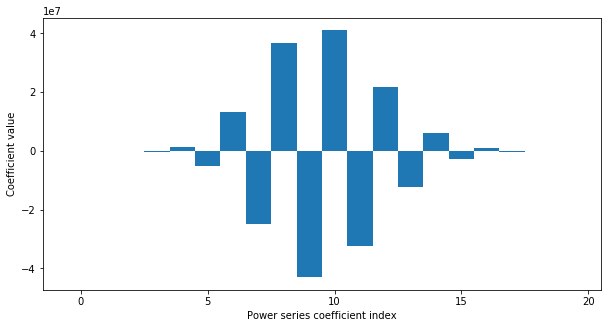

1. Evaluate the power series at \(x=20\) using the first 100 terms and compute the absolute and relative error (you can assume that ``np.sin`` is accurate). *Hint*: the factorial function is provided in ``scipy.special``.<br><br>

2. Express the error as an integer number of ULPs (see also Problem 3) -- in other words, how many floating point numbers are between the true and the approximate answer?<br><br>

3. Now, evaluate the exponential function at ``x=30`` using the same approach: using its corresponding power series, and assuming that ``np.exp`` is accurate. Specify the absolute and relative error. What do you observe compared to the sine power series? Why is this the case?<br><br>

4. List three different kinds of numerical problems that can arise when evaluating the above two power series with very many terms (e.g. thousands), and what parts of the expression specifically cause them.

## Solution - Q1

In [16]:
def taylor_sin(x):
    result = 0
    
    for i in range(100):
        result += (((-1)**i) * x**(2*i + 1)) / (factorial(2*i + 1))
        
    return result

sin_abs_err = taylor_sin(20) - np.sin(20)
sin_rel_err = sin_abs_err / np.sin(20)

print("sin function absolute error :", sin_abs_err)
print("sin function relative error :", sin_rel_err)

sin function absolute error : 5.546900161412793e-09
sin function relative error : 6.075830020466015e-09


## Solution - Q2

In [17]:
ulp_err = abs(f2i(f64(taylor_sin(20))) - f2i(f64(np.sin(20)))) - 1

print("Error as integers of ULP's :", ulp_err)

Error as integers of ULP's : 49962034.0


## Solution - Q3

In [18]:
def taylor_exp(x):
    result = 0
    
    for i in range(100):
        result += x**i / factorial(i)
    
    return result

exp_abs_err = taylor_exp(30) - np.exp(30)
exp_rel_err = exp_abs_err / np.exp(30)

print("Exponential function absolute error :", exp_abs_err)
print("Exponential function relative error :", exp_rel_err)

Exponential function absolute error : 0.00390625
Exponential function relative error : 3.655321472203193e-16


We can see that there's a quite big difference between the absolute and relative error for the exponential 
function compared to the sin function, where the difference is really small. We also notice that the absolute
error of the exponential function is bigger than the sin one. Then, exponential function logicly has a much
smaller relative error than the sin.

This is due to the way we compute the relative error : since we divide by the absolute error, a big absolute
error means a small relative error. Since the absolute error of the exponential is bigger than the sin one,
it has a much smaller relative error.

## Solution - Q4

Problems can occur with the power functions used in the series. With large values, this function 
would evaluate to values that are too big to be represented and hence lead to overflow.

We can also have round off errors due to the fact that the hability of the computer to represent values is limited.
If we perform a lot of iteration on the power series the round off error will acumulate since all the interations
are related.

Evaluating the Taylor Series with a lot of terms could cost a lot to the computer in terms of ressources since it 
will have to compute hudge values that don't add that much precision to the result. The 1000-th number of the 
Taylor Serie is much less important than the first ones.